# YOLO Segmentation Dataset Exploration

Este notebook permite explorar y validar el dataset en formato YOLO Instance Segmentation.
Diseñado para: `/home/rodrigo/Desktop/maestria/trash-detection/data/yolo_seg`

In [43]:
import os
import glob
import random
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
from tqdm import tqdm

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

In [44]:
# --- CONFIGURACIÓN ---
DATASET_ROOT = Path('/home/rodrigo/Desktop/maestria/trash-detection/data/yolo_seg')

if not DATASET_ROOT.exists():
    print(f"⚠️ Advertencia: La ruta {DATASET_ROOT} no existe.")
else:
    print(f"✅ Dataset encontrado en: {DATASET_ROOT}")

✅ Dataset encontrado en: /home/rodrigo/Desktop/maestria/trash-detection/data/yolo_seg


In [45]:
def load_class_names(dataset_path):
    """Carga nombres de clases desde data.yaml"""
    yaml_path = dataset_path / 'data.yaml'
    if yaml_path.exists():
        with open(yaml_path, 'r') as f:
            config = yaml.safe_load(f)
            if 'names' in config:
                return config['names']
    return {i: str(i) for i in range(100)}

CLASSES = load_class_names(DATASET_ROOT)
print(f"Clases detectadas: {len(CLASSES)}")

Clases detectadas: 23


In [46]:
def parse_yolo_label(label_path, img_width, img_height):
    """Lee polígonos de formato YOLO y los convierte a píxeles"""
    objects = []
    if not label_path.exists(): return objects
        
    with open(label_path, 'r') as f:
        lines = f.readlines()
        
    for line in lines:
        parts = line.strip().split()
        if len(parts) < 5: continue
        class_id = int(parts[0])
        coords = list(map(float, parts[1:]))
        points = []
        for i in range(0, len(coords), 2):
            x = int(coords[i] * img_width)
            y = int(coords[i+1] * img_height)
            points.append([x, y])
        objects.append({'class_id': class_id, 'points': np.array(points, dtype=np.int32)})
    return objects

def visualize_sample(image_path, label_path, class_names):
    img = cv2.imread(str(image_path))
    if img is None: return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    objects = parse_yolo_label(label_path, w, h)
    
    overlay = img.copy()
    np.random.seed(42)
    colors = np.random.randint(0, 255, (100, 3))
    
    for obj in objects:
        pts = obj['points']
        cid = obj['class_id']
        color = colors[cid % 100].tolist()
        label = class_names[cid] if isinstance(class_names, list) and cid < len(class_names) else str(cid)
        
        cv2.fillPoly(overlay, [pts], color)
        cv2.polylines(img, [pts], True, color, 2)
        cv2.putText(img, label, (pts[0][0], pts[0][1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
        
    result = cv2.addWeighted(overlay, 0.4, img, 0.6, 0)
    plt.imshow(result)
    plt.axis('off')
    plt.title(image_path.name)
    plt.show()

## 1. Inspección Visual

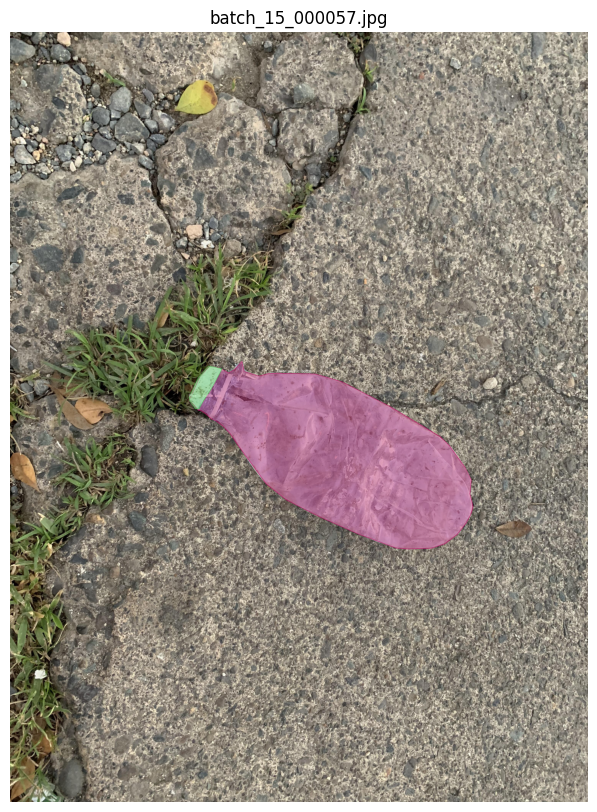

In [50]:
SPLIT = 'train'
img_dir = DATASET_ROOT / SPLIT / 'images'
lbl_dir = DATASET_ROOT / SPLIT / 'labels'

all_imgs = list(img_dir.glob('*.jpg')) + list(img_dir.glob('*.png'))
if all_imgs:
    rand_img = random.choice(all_imgs)
    rand_lbl = lbl_dir / (rand_img.stem + '.txt')
    visualize_sample(rand_img, rand_lbl, CLASSES)
else:
    print("No se encontraron imágenes.")

## 2. Escaneo de Errores (Polígonos Vacíos o Diminutos)

In [48]:
def scan_errors(split='train'):
    print(f"Escaneando {split}...")
    img_dir = DATASET_ROOT / split / 'images'
    lbl_dir = DATASET_ROOT / split / 'labels'
    imgs = list(img_dir.glob('*.*'))
    
    tiny_polys = []
    empty_files = []
    
    for img_p in tqdm(imgs):
        lbl_p = lbl_dir / (img_p.stem + '.txt')
        if not lbl_p.exists() or lbl_p.stat().st_size == 0:
            empty_files.append(img_p.name)
            continue
            
        with open(lbl_p) as f:
            for line in f:
                parts = line.split()
                if len(parts) > 5:
                    coords = list(map(float, parts[1:]))
                    xs, ys = coords[0::2], coords[1::2]
                    area = (max(xs)-min(xs)) * (max(ys)-min(ys))
                    if area < 0.0001:  # Threshold de tamaño
                        tiny_polys.append((img_p.name, area))

    print(f"\nResultados {split}:")
    print(f"- Sin etiquetas: {len(empty_files)}")
    print(f"- Polígonos ruido/diminutos: {len(tiny_polys)}")
    return tiny_polys

errores = scan_errors('train')

Escaneando train...


100%|██████████| 1110/1110 [00:00<00:00, 14858.80it/s]


Resultados train:
- Sin etiquetas: 0
- Polígonos ruido/diminutos: 238


Visualizando ejemplos de errores...
batch_10_000076.jpg - Area: 0.000033


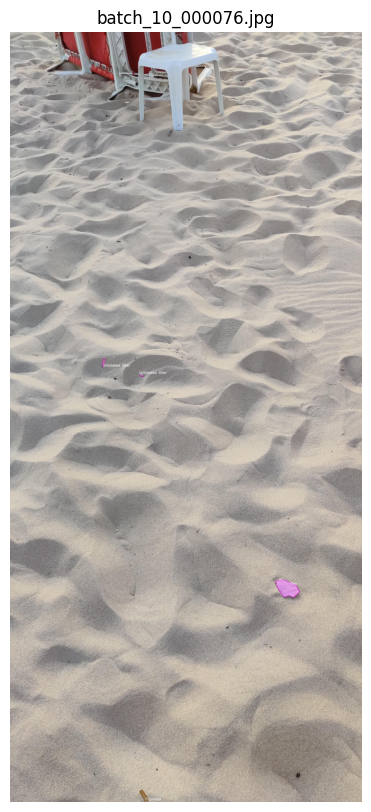

batch_2_000082.JPG - Area: 0.000057


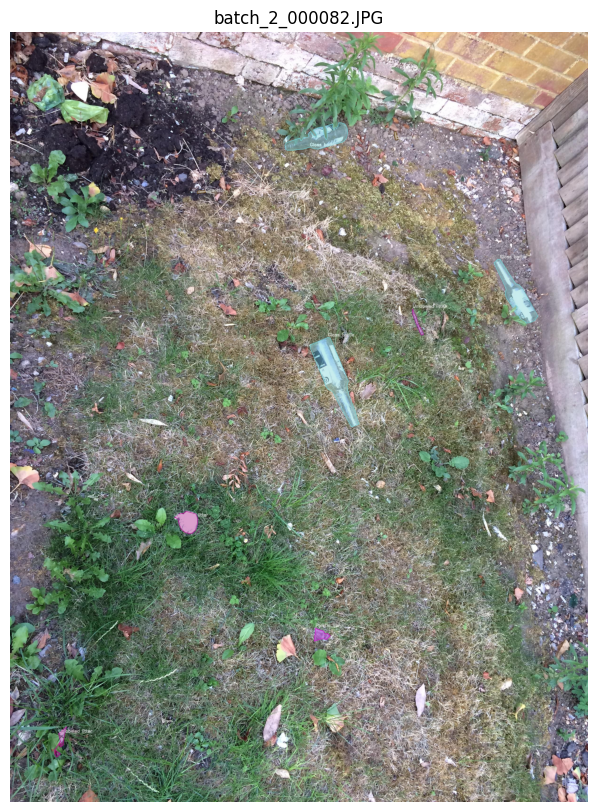

batch_2_000082.JPG - Area: 0.000081


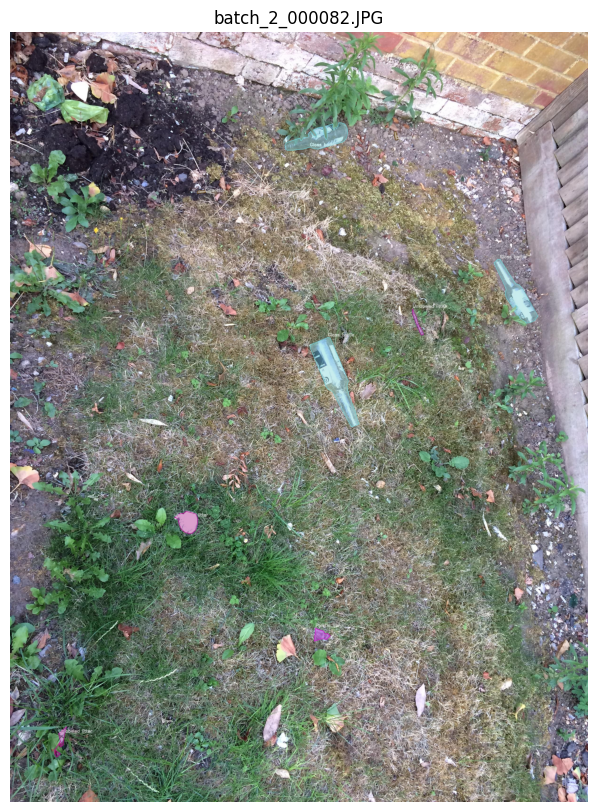

In [49]:
# Visualizar errores detectados
if errores:
    print("Visualizando ejemplos de errores...")
    for img_name, area in errores[:3]:
        print(f"{img_name} - Area: {area:.6f}")
        img_path = DATASET_ROOT / 'train' / 'images' / img_name
        lbl_path = DATASET_ROOT / 'train' / 'labels' / (Path(img_name).stem + '.txt')
        visualize_sample(img_path, lbl_path, CLASSES)